In [2]:
# Import libraries
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
aq_full = pd.read_csv('C:/Users/jorda/Documents/CMU/ML/AQ Project/aq_2016_full.csv')

# Switch it in to the main hourly df
hourly_aq = aq_full.copy()

In [ ]:
# Data that is subset to Liberty site
hourly_aq = pd.read_csv('C:/Users/jorda/Documents/CMU/ML/AQ Project/aq_liberty.csv')

print(hourly_aq.describe())
print(hourly_aq.columns)
print(hourly_aq.head)

print(hourly_aq['parameter'].unique())
print(hourly_aq['parameter'].value_counts())


                _id   report_value
count  6.550120e+05  645167.000000
mean   4.522200e+06      32.905389
std    2.808191e+06     121.290556
min    3.000000e+00  -20343.700000
25%    2.153127e+06       0.001000
50%    4.267696e+06       6.600000
75%    6.729519e+06      23.800000
max    1.013489e+07   53674.000000
Index(['_id', 'datetime_est', 'site', 'parameter', 'is_valid', 'report_value',
       'unit', 'unit_description', 'highest_flag', 'aqs_parameter_category'],
      dtype='object')
<bound method NDFrame.head of              _id         datetime_est     site parameter is_valid  \
0              3  2016-01-01T00:00:00  Liberty       SO2        t   
1              4  2016-01-01T00:00:00  Liberty   SONICWS        t   
2              5  2016-01-01T00:00:00  Liberty   SONICWD        t   
3              6  2016-01-01T00:00:00  Liberty       H2S        t   
4              7  2016-01-01T00:00:00  Liberty     OUT_T        t   
...          ...                  ...      ...       ...      

## Feature generation

In [5]:
# Pivot the parameters to be useful for feature work
hourly_feat = hourly_aq.pivot(index=['datetime_est', 'site'], columns='parameter', values='report_value').reset_index()

# We want multiple features from the date. Let's create a bunch
hourly_feat['datetime_est'] = pd.to_datetime(hourly_feat['datetime_est'])
hourly_feat['month'] = hourly_feat['datetime_est'].dt.month
hourly_feat['day'] = hourly_feat['datetime_est'].dt.day
hourly_feat['month_day'] = hourly_feat['datetime_est'].dt.strftime('%m-%d')
hourly_feat['hour'] = hourly_feat['datetime_est'].dt.hour
hourly_feat['weekday'] = hourly_feat['datetime_est'].dt.day_name()
hourly_feat['weekday_num'] = hourly_feat['datetime_est'].dt.weekday
hourly_feat['is_weekend'] = hourly_feat['weekday_num'].apply(lambda x: 1 if x >= 5 else 0)
hourly_feat['week_of_year'] = hourly_feat['datetime_est'].dt.isocalendar().week
hourly_feat['quarter'] = hourly_feat['datetime_est'].dt.quarter

def time_of_day(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
hourly_feat['time_of_day'] = hourly_feat['hour'].apply(time_of_day)

def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'
hourly_feat['season'] = hourly_feat['datetime_est'].apply(get_season)

hourly_feat.columns

Index(['datetime_est', 'site', 'BAMRAW', 'BCSTAT', 'BLACK CARBON', 'BP', 'CO',
       'Elev', 'H2S', 'H2S_SO2', 'INT_T', 'NO', 'NO2', 'NOX', 'NOY', 'NOYDIF',
       'OUT_RH', 'OUT_T', 'OZONE', 'OZONE2', 'OZONE_B', 'PER_F', 'PER_F2',
       'PM10', 'PM10A', 'PM10B', 'PM10RAW', 'PM10_FL', 'PM25', 'PM25(2)',
       'PM25B', 'PM25RAW', 'PM25T', 'PM25_FL', 'Peak Wind Gust', 'RAINFALL',
       'RH%', 'RWD', 'RWS', 'SIGTHETA', 'SO2', 'SO2PPM', 'SOLARRAD', 'SONICWD',
       'SONICWS', 'TAPE COUNT', 'TSP', 'UVPM', 'UV_RAD', 'WNDR', 'WNSP',
       'month', 'day', 'month_day', 'hour', 'weekday', 'weekday_num',
       'is_weekend', 'week_of_year', 'quarter', 'time_of_day', 'season'],
      dtype='object', name='parameter')

In [13]:
# Different stations use slightly different features for similar concepts. We
# would prefer to combine from a neighboring stations rather than impute.
meteorology_cols = [
    #'datetime_est', 'site',
    # Temp
    'OUT_T',
    # Wind
    'RWS', 'SONICWS', 'WNSP', 'Peak Wind Gust', 'SIGTHETA',
    # Wind dir
    'RWD', 'SONICWD', 'WNDR',
    # Other
    'BP', 'OUT_RH']

#meteorology = hourly_feat[meteorology_cols]

# Create indicator for missing values we are about to fill
#for col in meteorology_cols:
#    hourly_feat[f'{col}_filled'] = hourly_feat[col].isna().astype(int)

# Fillna from the average of other stations with values
hourly_feat[meteorology_cols] = hourly_feat.groupby(
    ['datetime_est'])[meteorology_cols].transform(
    lambda x: x.fillna(x.mean()))
#  Try faster method
#import swifter
#hourly_feat[meteorology_cols] = hourly_feat.groupby(
#    ['site', 'datetime_est'])[meteorology_cols].apply(
#    lambda x: x.swifter.apply(lambda y: y.fillna(y.mean())))

# Feature gen: convert wind direction from degrees to categorical direction
def wind_dir(degs):
    if 45 <= degs < 135:
        return 'E'
    elif 135 <= degs < 225:
        return 'S'
    elif 225 <= degs < 315:
        return 'W'
    elif 315 <= degs <= 360:
        return 'N'
    elif degs < 45:
        return 'N'
hourly_feat['wind_dir'] = hourly_feat['SONICWD'].apply(wind_dir)

Outcome selection and test split

In [ ]:
from sklearn.model_selection import train_test_split

# Proportion of NA in the result for each feature
hourly_feat.isna().mean()

# Define the outcome for this model
outcome = 'PM25' #'SO2', 'H2S', 'H2S_SO2', 'PM25', 'NO2'

# Prep for dropping rows, copying over so we don't have to rerun feature gen
hourly_feat2 = hourly_feat.copy()

# Drop NAs rows from outcome, since we don't want to impute outcomes
hourly_feat2.dropna(subset=[outcome], inplace=True)

# Now that we've removed uninteresting rows, remove the columns that only applied to those
hourly_feat2.dropna(axis=1, how='all', inplace=True)


# Different features are available based on the monitoring station
so2_feats = ['site', 'INT_T', 'OUT_T', 'BP', 'OUT_RH',
             'SIGTHETA', 'SONICWD', 'SONICWS', 'wind_dir', 'month', 'day',
              'hour', 'weekday', 'weekday_num', 'is_weekend',
              'week_of_year', 'quarter', 'time_of_day', 'season']
pm25_feats = []

# Drop rows with NAs in columns we will use
#hourly_feat2 = hourly_feat2[so2_feats, outcome]
# We have one observation from Fayette that is missing too much and causes problems
# Note: need to check this only drops 1 row (or is even necessary) when using different datasets
hourly_feat2 = hourly_feat2.dropna(subset=['SONICWD'])

# Select features and label for model
X = hourly_feat2[so2_feats]
y = hourly_feat2[outcome] 

# How much NA in rows do we have left after subsetting to features? This will be imputed
null_in_rows = X[X.isnull().any(axis=1)]
print(null_in_rows.shape)

# Split out test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)


(18, 19)


ML model selection

In [22]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

imp = SimpleImputer()
#imp_iter = IterativeImputer()
ohe = OneHotEncoder()

ct = make_column_transformer(
       (imp, ['OUT_T', 'INT_T', 'SIGTHETA', 'SONICWD', 'SONICWS', 'BP',
              'OUT_RH']),
       (ohe, ['site', 'time_of_day', 'season', 'weekday', 'wind_dir']),
       remainder = 'passthrough'
)

In [ ]:
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import AdaBoostRegressor, HistGradientBoostingRegressor #RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, cross_validate

pipelines = {
    "Linear Regression": make_pipeline(ct, LinearRegression()),
    "Ridge Regression": make_pipeline(ct, Ridge()),
    "Lasso Regression": make_pipeline(ct, Lasso()),
    #"Random Forest": make_pipeline(ct, RandomForestRegressor(max_depth=10)),
    "XGBoost": make_pipeline(ct, XGBRegressor()),
    "AdaBoost": make_pipeline(ct, AdaBoostRegressor()),
    "GradientBoost": make_pipeline(ct, HistGradientBoostingRegressor()),
    #"SVR": make_pipeline(ct, scaler, SVR())  # Scale features for SVR
}

from sklearn.metrics import make_scorer, root_mean_squared_error, mean_absolute_error, r2_score

val_metrics = {
    "RMSE": make_scorer(root_mean_squared_error),
    "MAE": make_scorer(mean_absolute_error),
    "R-Squared": make_scorer(r2_score)
}

# Evaluate pipelines using cross-validation
for name, pipeline in pipelines.items():
    print(f"{name}:")
    scores = cross_validate(pipeline, X, y, cv=5, scoring=val_metrics, return_train_score=False)
    for metric_name in val_metrics.keys():
        mean_score = scores[f'test_{metric_name}'].mean()
        print(f"{metric_name}: {mean_score:.4f}")
    print()
    #for metric_name, metric in val_metrics.items():
    #    score = cross_val_score(pipeline, X, y, cv=5, scoring=metric).mean()
    #    print(f"{metric_name}: {score:.4f}")
    #print()


Linear Regression:
RMSE: 0.3894
MAE: 0.1509
R-Squared: 0.2889

Ridge Regression:
RMSE: 0.3894
MAE: 0.1509
R-Squared: 0.2890

Lasso Regression:
RMSE: 0.4606
MAE: 0.2048
R-Squared: -0.0024

XGBoost:
RMSE: 0.4035
MAE: 0.1059
R-Squared: 0.2199

AdaBoost:
RMSE: 0.7911
MAE: 0.5553
R-Squared: -3.2668

GradientBoost:
RMSE: 0.3734
MAE: 0.0918
R-Squared: 0.3380



In [ ]:
# Evaluation on test set



In [ ]:
# Exploration of feature importance of various models

def get_coeffients(pipeline, model_name):
    '''Get coefficients/p-values (proxy for feature importance) for the
    regression models'''
    pipeline.fit(X, y)
    coefficients = pipeline.named_steps[model_name].coef_
    feature_names = ct.get_feature_names_out()
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', key=abs, ascending=False)
    return importance_df

linear_importance = get_coeffients(pipelines['Linear Regression'], 'linearregression')
ridge_importance = get_coeffients(pipelines['Ridge Regression'], 'ridge')
lasso_importance = get_coeffients(pipelines['Lasso Regression'], 'lasso')

print("Linear Regression:")
print(linear_importance)

print("\nRidge Regression:")
print(ridge_importance)

print("\nLasso Regression:")
print(lasso_importance)



Linear Regression:
                                 Feature  Coefficient
8    onehotencoder__site_Lawrenceville 2     0.510525
10    onehotencoder__site_North Braddock    -0.139380
7             onehotencoder__site_Avalon    -0.139057
9            onehotencoder__site_Liberty    -0.118720
11     onehotencoder__site_South Fayette    -0.113367
19          onehotencoder__season_Winter     0.048434
14    onehotencoder__time_of_day_Morning     0.045861
13    onehotencoder__time_of_day_Evening    -0.036829
17          onehotencoder__season_Spring    -0.036333
26      onehotencoder__weekday_Wednesday     0.025103
21         onehotencoder__weekday_Monday    -0.018439
29             onehotencoder__wind_dir_S     0.016494
15      onehotencoder__time_of_day_Night    -0.016134
4                 simpleimputer__SONICWS    -0.011544
37                    remainder__quarter    -0.009464
30             onehotencoder__wind_dir_W    -0.009370
18          onehotencoder__season_Summer    -0.007946
12  oneho

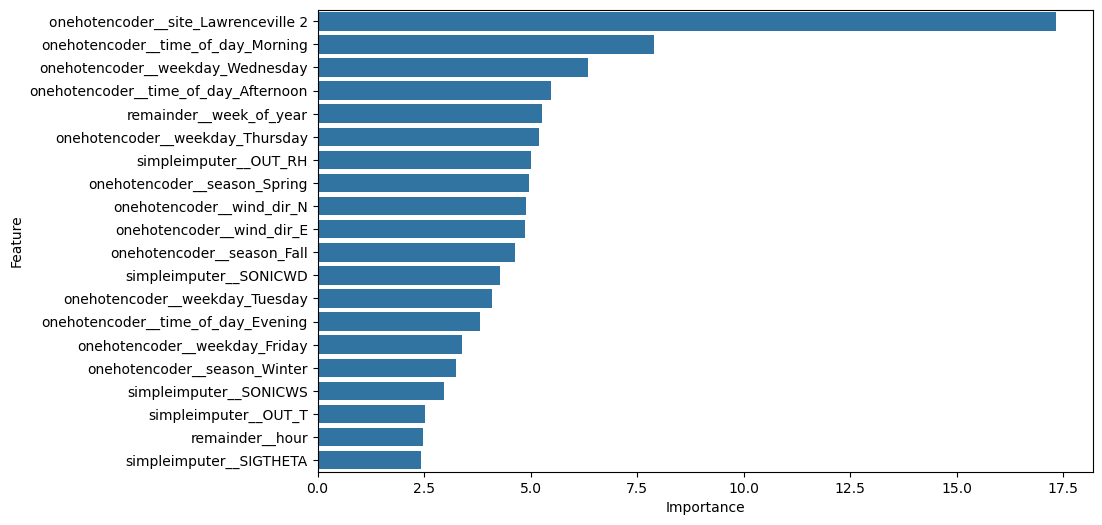

In [30]:
# Feature importance for XGBoost. We need to retrain, since results aren't available from xval above.
from sklearn.model_selection import cross_validate

xgb_cv = cross_validate(pipelines['XGBoost'], X, y, cv=5, return_estimator=True,
    #scoring='neg_root_mean_squared_error'
)
xgb_feats = xgb_cv['estimator'][0].named_steps['columntransformer'].get_feature_names_out()
xgb_importance = np.zeros((len(xgb_cv['estimator']), len(xgb_feats)))

# We want to average importance across folds
for i, model in enumerate(xgb_cv['estimator']):
    booster = model.named_steps['xgbregressor'].get_booster()
    importances = booster.get_score(importance_type='gain')
    
    for j in range(len(xgb_feats)):
        xgb_importance[i, j] = importances.get(f'f{j}', 0)

xgb_importance = pd.DataFrame({'Feature': xgb_feats, 'Importance': xgb_importance.mean(axis=0)
}).sort_values(by='Importance', ascending=False)
xgb_importance

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance.head(20), x='Importance', y='Feature')
plt.show()


In [31]:
# Sklearn doesn't give us p-values, which would be useful to know for the simple linear model
import statsmodels.api as sm

# Preprocess X again, since we can't use pipelines outside sklearn
X_transformed = ct.fit_transform(X)

# Convert pack to df to keep colnames
X_transformed = pd.DataFrame(X_transformed, columns=ct.get_feature_names_out(input_features=X.columns))
X_transformed = sm.add_constant(X_transformed)

# Annoying type conversion for indexes, since sm is finicky
y.index = pd.RangeIndex(start=0, stop=len(y), step=1)

lin_mod = sm.OLS(y, X_transformed.astype(float)).fit()
print(lin_mod.summary())

                            OLS Regression Results                            
Dep. Variable:                    SO2   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     1159.
Date:                Tue, 15 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:43:33   Log-Likelihood:                -37144.
No. Observations:               78652   AIC:                         7.435e+04
Df Residuals:                   78620   BIC:                         7.465e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
